<a href="https://colab.research.google.com/github/uni-3/jupyter-notebooks/blob/master/uplift_trees_with_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. The package currently supports the following methods:

Tree-based algorithms
* Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
* Uplift tree/random forests on Contextual Treatment Selection

Meta-learner algorithms
* S-learner
* T-learner
* X-learner
* R-learner

In this notebook, we use synthetic data to demonstrate the use of the tree-based algorithms.

In [0]:
!pip install -U setuptools>=41.0.0 pip>=10.0 numpy>=0.16.0 "scipy<1.3.0" matplotlib==2.2.4  pandas>=0.25.1 scikit-learn==0.20.3  statsmodels>=0.9.0 seaborn Cython xgboost==0.82 future


In [2]:
!pip install causalml

In [0]:
import numpy as np
import pandas as pd

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain

from sklearn.model_selection import train_test_split

## Generate synthetic dataset

データ生成


In [0]:
df, x_names = make_uplift_classification()

In [5]:
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,x10_irrelevant,x11_uplift_increase,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,-0.934969,0.656869,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,-0.356051,1.050526,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,1.374859,1.072329,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,-1.957101,1.398966,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,-0.824105,1.398327,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0


In [6]:
x_names

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_irrelevant',
 'x7_irrelevant',
 'x8_irrelevant',
 'x9_irrelevant',
 'x10_irrelevant',
 'x11_uplift_increase',
 'x12_uplift_increase',
 'x13_increase_mix',
 'x14_uplift_increase',
 'x15_uplift_increase',
 'x16_increase_mix',
 'x17_uplift_increase',
 'x18_uplift_increase',
 'x19_increase_mix']

In [7]:
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


# Run the uplift random forest classifier

In this section, we first fit the uplift random forest classifier using training data. We then use the fitted model to make a prediction using testing data. The prediction returns an ndarray in which each column contains the predicted uplift if the unit was in the corresponding treatment group.

学習させる。testデータを使って予測、treatmentに対して、uplift具合がわかる

In [0]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

In [0]:
uplift_model = UpliftRandomForestClassifier(control_name='control')

In [0]:
uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [0]:
y_pred = uplift_model.predict(df_test[x_names].values)

In [0]:
# Put the predictions to a DataFrame for a neater presentation
# 各群がどこのクラスにいるか？？？
result = pd.DataFrame(y_pred,
                      columns=uplift_model.classes_)

In [13]:
# 各群へのスコア
result

,treatment1,treatment2,treatment3
0,-0.052461,0.028544,0.062568
1,0.001432,0.090935,0.004034
2,0.030645,0.110449,-0.014406
3,0.042346,0.039590,0.360335
4,0.017587,0.118971,0.331485
...,...,...,...
795,0.086275,0.105316,0.406309
796,-0.035968,0.031619,0.032262
797,-0.019312,0.070419,0.055174
798,0.024296,0.096761,-0.031588


# Create the uplift curve

The performance of the model can be evaluated with the help of the [uplift curve](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdfc). 

## Create a synthetic population

The uplift curve is calculated on a synthetic population that consists of those that were in the control group and those who happened to be in the treatment group recommended by the model. We use the synthetic population to calculate the _actual_ treatment effect within _predicted_ treatment effect quantiles. Because the data is randomized, we have a roughly equal number of treatment and control observations in the predicted quantiles and there is no self selection to treatment groups.

 synthetic population、control groupとtreatment group、（モデルにレコメンド：予測された？）からなる

 実際の効果を予測結果から測定する、self selection(自己相関的な？)はない？ランダムに生成した値なので、

In [0]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
# -の人はcontrolになる、その他は、一番大きい所のtreatmentになる
best_treatment = np.where((result < 0).all(axis=1),
                           'control',
                           result.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
# 実際に該当するグループだったか、もしくはcontrolだったか
actual_is_best = np.where(df_test['treatment_group_key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test['treatment_group_key'] == 'control', 1, 0)

In [0]:
# synthetic population作成
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

## Calculate the observed treatment effect per predicted treatment effect quantile

We use the observed treatment effect to calculate the uplift curve, which answers the question: how much of the total cumulative uplift could we have captured by targeting a subset of the population sorted according to the predicted uplift, from highest to lowest?

CausalML has the plot_gain() function which calculates the uplift curve given a DataFrame containing the treatment assignment, observed outcome and the predicted treatment effect.

観察結果の効果をuplist curveから測定。

In [16]:
df_test['conversion']

2912    0
3509    0
3098    1
3847    0
1155    1
       ..
812     1
993     1
936     1
1927    1
154     0
Name: conversion, Length: 800, dtype: int64

In [0]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test.loc[synthetic, 'conversion'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_model.classes_)))

In [18]:
auuc_metrics.groupby('is_treated').sum()

,conversion,uplift_tree
is_treated,,
0,97,28.046948
1,114,26.136761


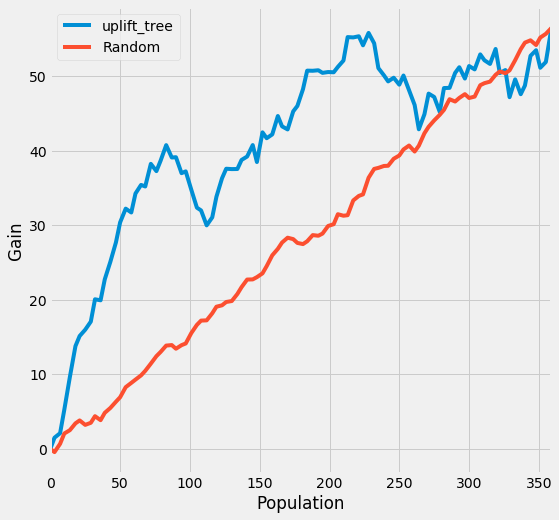

In [19]:
# conversionは 1/0
# 左が、population少ない、すなわちcontrolを混ぜない？つまり実験群の方が、効果が大きい？
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')